In [ ]:
API_URL = "https://api.helmholtz-blablador.fz-juelich.de/v1/"
API_KEY = ""
API_MODEL = "10 Mistral-Nemo-Instruct-2407 - Our fast-experimental - with a large context size"

from openai import OpenAI

client = OpenAI(
    api_key=API_KEY,
    base_url=API_URL
)

In [60]:
import pandas as pd

df_results_all = pd.DataFrame()

In [59]:

positions = [0, 4, 9, 14, 19]  
rel3_count = 1           
rel0_count = 19
sample_count = rel0_count + 1 
max_qids = 40            

In [ ]:

import pandas as pd

from slt_positional_bias.dataset import generate_merged_data_frame, sort_data_frame, store_df_as_parquet, load_parquet_as_df

# Liste für Ergebnisse
results = []
results_eval = []
df_final = load_parquet_as_df("output_cleaned_df")

topic_ids = df_final['topic_id'].unique()[:max_qids]

for topic_id in topic_ids:
    df_topic = df_final[df_final['topic_id'] == topic_id]

    # Relevante und irrelevante Dokumente holen
    rel_3_docs = df_topic[df_topic['rel_scoring'] == 3].head(rel3_count)
    rel_0_docs = df_topic[df_topic['rel_scoring'] == 0].head(rel0_count)

    query = rel_3_docs['topic'].iloc[0]
    rel_3_text = ' '.join(rel_3_docs['doc'].tolist())
    rel_0_texts = rel_0_docs['doc'].tolist()

    for pos in positions:
        # Kontext aufbauen
        text_list = rel_0_texts.copy()
        if pos >= len(text_list):
            text_list.append(rel_3_text)
        else:
            text_list.insert(pos, rel_3_text)

        context_string = ' '.join(text_list)

        # Prompt erstellen
        user_prompt = f"""
        Context:
        {context_string}

        Question:
        {query}

        Answer:"""
        system_prompt = "You are a helpful assistant answering a question based on retrieved context information."

        # Modell antworten lassen
        response = client.chat.completions.create(
            model=API_MODEL,
            temperature=0.4,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
        )
        answer = response.choices[0].message.content.strip()

        results_eval.append({
            'topic_id': topic_id,
            'topic' : query,
            'rel_3_doc_position': pos,
            'nr_rel_3_doc': rel3_count,
            'nr_rel_0_doc': rel0_count,
            'oracle': rel_3_text,
            'answer': answer
        })
 
        evaluation_prompt = f"""
        You are evaluating a language model's answer based on a context of {sample_count} sections: one highly relevant, and {rel0_count} irrelevant.

        Only the following section is relevant:
        \"\"\"{rel_3_text}\"\"\"

        This is Answer from the model based on {sample_count} sections:
        \"\"\"{answer}\"\"\"

        Question:
        Is the answer mainly based on the relevant section?

        Reply with exactly one word: Yes or No
        """
        eval_response = client.chat.completions.create(
            model=API_MODEL,
            temperature=0,
            messages=[
                {"role": "user", "content": evaluation_prompt}
                ],
        )
        eval_result = eval_response.choices[0].message.content.strip()

        # Speichern
        results.append({
            'topic_id': topic_id,
            'position': pos,
            'eval_result': eval_result
        })
        

# DataFrame erstellen
df_results = pd.DataFrame(results)
df_results_eval = pd.DataFrame(results_eval)

# An globalen Speicher anhängen (wenn vorhanden)
try:
    df_results_all = pd.concat([df_results_all, df_results], ignore_index=True)
except NameError:
    df_results_all = df_results.copy()

# Ergebnisse anzeigen
print("\nEval-Ergebnisse (Stichprobe):")
print(df_results_all['eval_result'].value_counts())


In [48]:
store_df_as_parquet(df_results_eval, f"LLM-{API_MODEL}-sample-count-{sample_count}")
df_results_eval

2025-08-09 15:58:34.264 | INFO     | slt_positional_bias.dataset:store_df_as_parquet:133 - Data frame saved to C:\Users\marti\slt_group_2_positional_bias\data\processed\LLM-1 - Llama3 405 the best general model and big context size-sample-count-20-1-2025-08-09 15h-58m-34s.parquet


,topic_id,topic,rel_3_doc_position,nr_rel_3_doc,nr_rel_0_doc,oracle,answer
0,2024-127266,what are some key challenges related to the re...,0,1,19,the e-waste recycling industry faces significa...,Some key challenges related to the recycling o...
1,2024-127266,what are some key challenges related to the re...,4,1,19,the e-waste recycling industry faces significa...,"According to the context, some key challenges ..."
2,2024-127266,what are some key challenges related to the re...,9,1,19,the e-waste recycling industry faces significa...,Some key challenges related to the recycling o...
3,2024-127266,what are some key challenges related to the re...,14,1,19,the e-waste recycling industry faces significa...,Some key challenges related to the recycling o...
4,2024-127266,what are some key challenges related to the re...,19,1,19,the e-waste recycling industry faces significa...,"According to the provided context, some key ch..."
...,...,...,...,...,...,...,...
195,2024-96063,how using maps can impact your pedagogy,0,1,19,maps and map learning play a critical role in ...,Using maps in pedagogy can have a significant ...
196,2024-96063,how using maps can impact your pedagogy,4,1,19,maps and map learning play a critical role in ...,Using maps can significantly impact pedagogy b...
197,2024-96063,how using maps can impact your pedagogy,9,1,19,maps and map learning play a critical role in ...,Using maps can significantly impact pedagogy b...
198,2024-96063,how using maps can impact your pedagogy,14,1,19,maps and map learning play a critical role in ...,Using maps can significantly impact pedagogy b...


In [51]:
store_df_as_parquet(df_results_all, "results15")

2025-08-09 16:48:18.527 | INFO     | slt_positional_bias.dataset:store_df_as_parquet:133 - Data frame saved to C:\Users\marti\slt_group_2_positional_bias\data\processed\results15-1-2025-08-09 16h-48m-18s.parquet


In [28]:
df_results_all = load_parquet_as_df("results12")

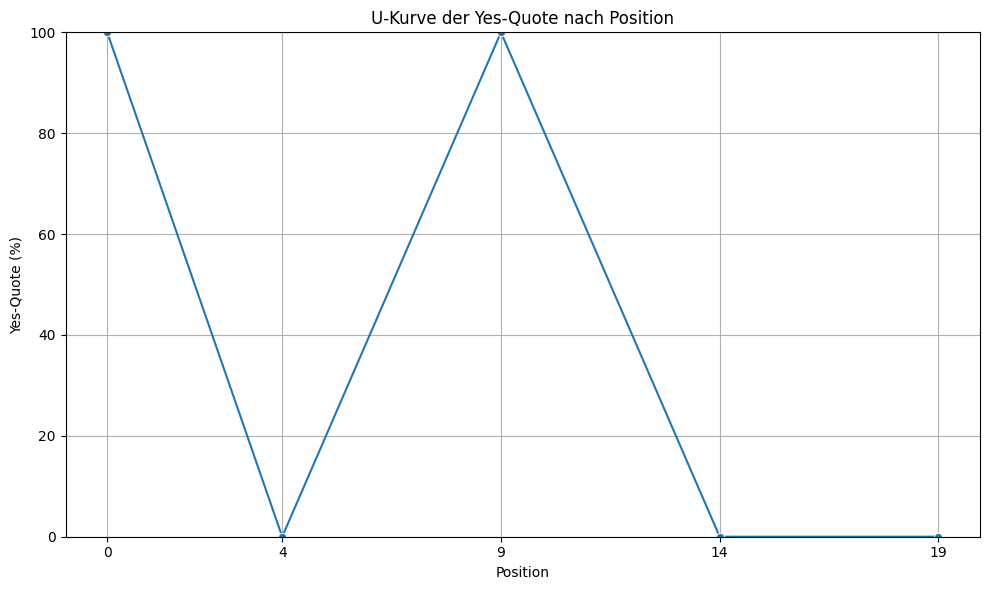

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_results_all['is_yes'] = df_results_all['eval_result'].apply(
    lambda x: x.split("</think>")[-1].strip().lower().startswith("yes")
).astype(int)

u_curve_df = df_results_all.groupby('position')['is_yes'].agg(['mean', 'count'])
u_curve_df.rename(columns={'mean': 'yes_rate', 'count': 'num_samples'}, inplace=True)
u_curve_df = u_curve_df.reset_index()
u_curve_df['yes_rate_pct'] = u_curve_df['yes_rate'] * 100

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=u_curve_df,
    x='position',
    y='yes_rate_pct',
    marker='o'
)

positions = u_curve_df['position'].unique()
plt.xticks(positions) 

plt.title('U-Kurve der Yes-Quote nach Position')
plt.xlabel('Position')
plt.ylabel('Yes-Quote (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()